In [16]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import spearmanr
from mfbml.methods.mf_dnn_bnn import MFDNNBNN
from mfbml.methods.bnn import BNNWrapper
from mfbml.methods.sequential_mf_bnn import SequentialMFBNN
from mfbml.problem_sets.torch_problems import MengCase1
from mfbml.get_methods.accuracy_metrics import (
    log_likelihood_value,
    normalized_mae,
    normalized_rmse,
)

In [2]:
# define function
func = MengCase1(noise_std=0.05)
num_dim = 1

# generate samples (21 HF samples, 201 LF samples)
lf_samples = torch.linspace(0, 1, 201).reshape(-1, 1)
hf_samples = lf_samples[::10]  # sample every 5 points

# generate responses
lf_responses = func.lf(lf_samples)
hf_responses = func.hf(hf_samples)

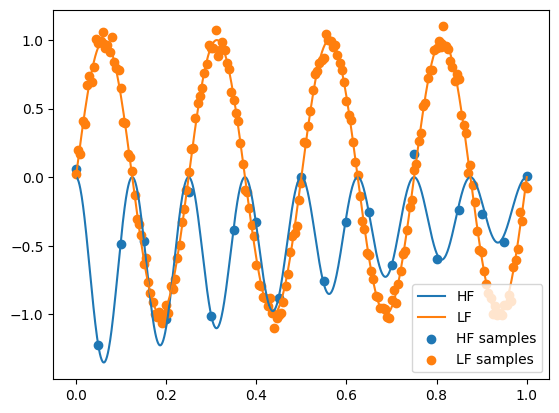

In [3]:
# generate the test points
test_samples = torch.linspace(0, 1, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)
test_lf_responses_noiseless = func.lf(test_samples, noise_lf=0.0)

# noise responses
test_hf_responses = func.hf(test_samples)
test_lf_responses = func.lf(test_samples)

# plot the function
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf_responses_noiseless, label="LF")
# plot test noisy responses
# ax.scatter(test_samples, test_hf_responses, label="HF noise responses")
# ax.scatter(test_samples, test_lf_responses, label="LF noise responses")
# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf_responses, label="LF samples")
plt.legend()
plt.show()

In [4]:
# calculate the person correlation coefficient via the noiseless responses
rho, pval = spearmanr(
    test_hf_responses_noiseless.numpy(), test_lf_responses_noiseless.numpy()
)
print("rho: ", rho)
print("pval: ", pval)

rho:  -0.08080117933899111
pval:  0.010545081375216493


## Configurations for DNN and BNNs


In [5]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [20, 20],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 0.000001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_parallel_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}
#
hf_sequential_configure = {
    "in_features": 2,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}

# training configure
samples = {"lf": lf_samples, "hf": hf_samples}

responses = {"lf": lf_responses, "hf": hf_responses}

# lf train config
lf_train_config = {"batch_size": None, "num_epochs": 20000, "print_iter": 100}
hf_train_config = {
    "num_epochs": 50000,
    "sample_freq": 100,
    "print_info": True,
    "burn_in_epochs": 30000,
}

### train standard BNN using HF data


In [6]:
# define BNN
bnn_model = BNNWrapper(
    in_features=1,
    hidden_features=[50, 50],
    out_features=1,
    activation="Tanh",
    lr=0.001,
    sigma=0.05,
)

# train the model
bnn_model.train(
    x=hf_samples,
    y=hf_responses,
    num_epochs=50000,
    sample_freq=100,
    burn_in_epochs=30000,
)

/home/jiaxiangyi/Documents/mfbml/src/mfbml/methods/bnn.py:170: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  V.mul_(alpha).addcmul_(1 - alpha, d_p, d_p)


epoch:     1/50000
nll_loss: 1274.964, prior_loss: 2507.302, total: 3782.266
noise: 0.050
epoch:   101/50000
nll_loss: 485.357, prior_loss: 2555.123, total: 3040.480
noise: 0.050
epoch:   201/50000
nll_loss: 469.263, prior_loss: 2592.607, total: 3061.870
noise: 0.050
epoch:   301/50000
nll_loss: 470.095, prior_loss: 2634.190, total: 3104.285
noise: 0.050
epoch:   401/50000
nll_loss: 473.162, prior_loss: 2680.620, total: 3153.781
noise: 0.050
epoch:   501/50000
nll_loss: 465.942, prior_loss: 2722.859, total: 3188.801
noise: 0.050
epoch:   601/50000
nll_loss: 464.360, prior_loss: 2762.469, total: 3226.829
noise: 0.050
epoch:   701/50000
nll_loss: 465.785, prior_loss: 2806.074, total: 3271.859
noise: 0.050
epoch:   801/50000
nll_loss: 466.843, prior_loss: 2858.848, total: 3325.690
noise: 0.050
epoch:   901/50000
nll_loss: 460.081, prior_loss: 2905.518, total: 3365.599
noise: 0.050
epoch:  1001/50000
nll_loss: 464.460, prior_loss: 2950.170, total: 3414.630
noise: 0.050
epoch:  1101/50000
n

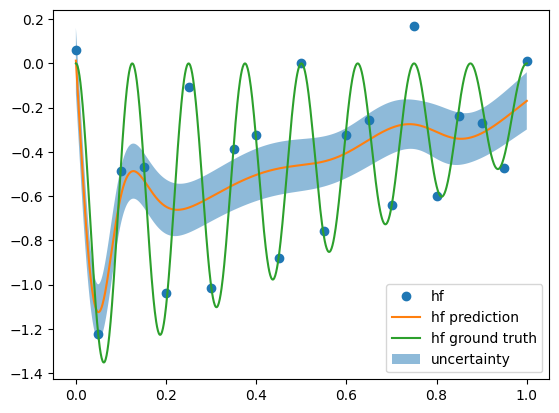

In [7]:
# visualize the posterior of bnn
bnn_y, bnn_epistemic, bnn_total_unc, bnn_aleatoric = bnn_model.predict(
    x=test_samples)

# plot
plt.figure()
plt.plot(hf_samples, hf_responses, "o", label="hf")
plt.plot(test_samples.numpy(), bnn_y, label="hf prediction")
plt.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
plt.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_total_unc).reshape(-1),
    (bnn_y + 2 * bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
plt.legend()
# plt.savefig("bnn.png", bbox_inches='tight', dpi=300)
plt.show()

# training of sequential MF-DNN-BNN model


In [8]:
# sequential mf-bnn
sequential_bnn = SequentialMFBNN(
    lf_configure=lf_configure, hf_configure=hf_sequential_configure
)
# train the model
sequential_bnn.train(
    samples=samples,
    responses=responses,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

epoch:  99 loss:  0.49146535992622375
epoch:  199 loss:  0.488410085439682
epoch:  299 loss:  0.48828190565109253
epoch:  399 loss:  0.48826321959495544
epoch:  499 loss:  0.48824214935302734
epoch:  599 loss:  0.48821836709976196
epoch:  699 loss:  0.4881916046142578
epoch:  799 loss:  0.4881616234779358
epoch:  899 loss:  0.48812782764434814
epoch:  999 loss:  0.48808926343917847
epoch:  1099 loss:  0.488044410943985
epoch:  1199 loss:  0.4879905879497528
epoch:  1299 loss:  0.487923800945282
epoch:  1399 loss:  0.4878375232219696
epoch:  1499 loss:  0.48772111535072327
epoch:  1599 loss:  0.4875567853450775
epoch:  1699 loss:  0.48731228709220886
epoch:  1799 loss:  0.4869195818901062
epoch:  1899 loss:  0.48618894815444946
epoch:  1999 loss:  0.4843825101852417
epoch:  2099 loss:  0.4793790876865387
epoch:  2199 loss:  0.4707847237586975
epoch:  2299 loss:  0.4571351706981659
epoch:  2399 loss:  0.43195414543151855
epoch:  2499 loss:  0.4142870306968689
epoch:  2599 loss:  0.403719

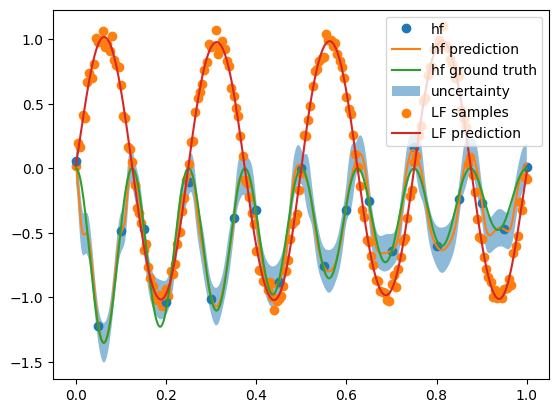

In [12]:
# visualize the posterior of sequential mf-bnn
(
    sequential_bnn_y,
    sequential_bnn_epistemic,
    sequential_bnn_total_unc,
    sequential_bnn_aleatoric,
) = sequential_bnn.predict(x=test_samples)
# get lf predictions
sequential_bnn_lf_y = sequential_bnn.lf_model.forward(x=test_samples)
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), sequential_bnn_y, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (sequential_bnn_y - 2 * sequential_bnn_total_unc).reshape(-1),
    (sequential_bnn_y + 2 * sequential_bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf_responses, label="LF samples")
ax.plot(
    test_samples.numpy(), sequential_bnn_lf_y.detach().numpy(), label="LF prediction"
)
ax.legend()
plt.show()

In [43]:
# create the MFDNNBNN object
mfdnnbnn = MFDNNBNN(
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=False,
    beta_bounds=[-5, 5],
)
# define beta
mfdnnbnn.beta = np.array([3.0])
mfdnnbnn.train(
    samples=samples,
    responses=responses,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)
# predict the MFDNNBNN object
(
    y_proposed,
    epistemic_proposed,
    total_unc_proposed,
    aleatoric_proposed,
) = mfdnnbnn.predict(x=test_samples)
# lf prediction
lf_y_proposed = mfdnnbnn.lf_model.forward(test_samples)

epoch:  99 loss:  0.48811978101730347
epoch:  199 loss:  0.48805931210517883
epoch:  299 loss:  0.48798272013664246
epoch:  399 loss:  0.48788800835609436
epoch:  499 loss:  0.4877689480781555
epoch:  599 loss:  0.4876108169555664
epoch:  699 loss:  0.4873836040496826
epoch:  799 loss:  0.48702266812324524
epoch:  899 loss:  0.48634812235832214
epoch:  999 loss:  0.48407408595085144
epoch:  1099 loss:  0.471306711435318
epoch:  1199 loss:  0.44151419401168823
epoch:  1299 loss:  0.4196362793445587
epoch:  1399 loss:  0.4062960743904114
epoch:  1499 loss:  0.38745784759521484
epoch:  1599 loss:  0.367221862077713
epoch:  1699 loss:  0.3201979100704193
epoch:  1799 loss:  0.2575620412826538
epoch:  1899 loss:  0.21310237050056458
epoch:  1999 loss:  0.18334408104419708
epoch:  2099 loss:  0.08116336166858673
epoch:  2199 loss:  0.023225238546729088
epoch:  2299 loss:  0.013970076106488705
epoch:  2399 loss:  0.012269440107047558
epoch:  2499 loss:  0.011188540607690811
epoch:  2599 loss:

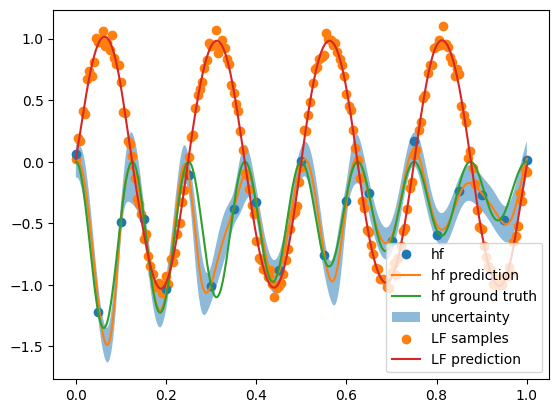

In [40]:
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), y_proposed, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).reshape(-1),
    (y_proposed + 2 * total_unc_proposed).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf_y_proposed.detach().numpy(),
        label="LF prediction")
ax.legend()
plt.show()

In [41]:
# get the accuracy metrics
print("=====================================")
print("BNN")
nrmse_bnn = normalized_rmse(test_hf_responses_noiseless.numpy(), bnn_y)
print("nrmse: ", nrmse_bnn)
nmae_bnn = normalized_mae(test_hf_responses_noiseless.numpy(), bnn_y)
print("nmae: ", nmae_bnn)
ll_bnn = log_likelihood_value(test_hf_responses.numpy(), bnn_y, bnn_total_unc)
print("ll_bnn: ", ll_bnn)
# sequential mf-bnn
print("=====================================")
print("Sequential MF-BNN")
nrmse_sequential_bnn = normalized_rmse(
    test_hf_responses_noiseless.numpy(), sequential_bnn_y
)
print("nrmse: ", nrmse_sequential_bnn)
nmae_sequential_bnn = normalized_mae(
    test_hf_responses_noiseless.numpy(), sequential_bnn_y
)
print("nmae: ", nmae_sequential_bnn)
ll_sequential_bnn = log_likelihood_value(
    test_hf_responses.numpy(),
    sequential_bnn_y,
    sequential_bnn_total_unc,
)
print("ll_sequential_bnn: ", ll_sequential_bnn)
# MFDNNBNN
print("=====================================")
print("MFDNNBNN")
nrmse_mfdnnbnn = normalized_rmse(test_hf_responses_noiseless.numpy(), y_proposed)
print("nrmse: ", nrmse_mfdnnbnn)
nmae_mfdnnbnn = normalized_mae(test_hf_responses_noiseless.numpy(), y_proposed)
print("nmae: ", nmae_mfdnnbnn)
ll_mfdnnbnn = log_likelihood_value(
    test_hf_responses.numpy(), y_proposed, total_unc_proposed
)
print("ll_mfdnnbnn: ", ll_mfdnnbnn)

BNN
nrmse:  0.6732121
nmae:  1.4279178
ll_bnn:  -12098.285
Sequential MF-BNN
nrmse:  0.18076047
nmae:  0.7089347
ll_sequential_bnn:  860.5698
MFDNNBNN
nrmse:  0.2864935582719598
nmae:  1.1076690660581554
ll_mfdnnbnn:  410.8477482439666


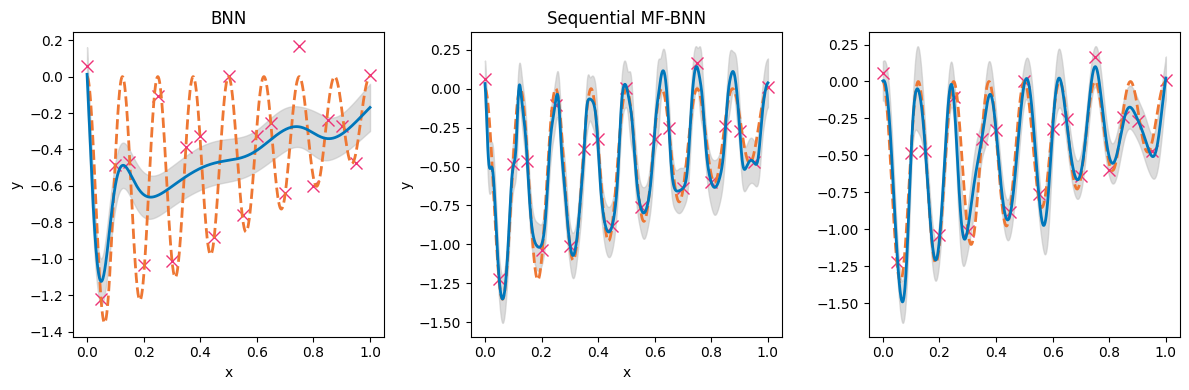

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# plot results of bnn
ax[0].plot(
    samples["hf"].numpy(),
    responses["hf"].numpy(),
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=8,
    label="HF samples",
)
ax[0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#EE7733",
    linewidth=2,
    label="HF noiseless truth",
)
ax[0].plot(
    test_samples.numpy(),
    bnn_y,
    "-",
    color="#0077BB",
    linewidth=2,
    label="HF prediction",
)
ax[0].fill_between(
    test_samples.flatten(),
    (bnn_y - 2 * bnn_total_unc).flatten(),
    (bnn_y + 2 * bnn_total_unc).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# ax[0].legend()
ax[0].set_title("BNN")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

#  plot for sequential mf-bnn
ax[1].plot(
    samples["hf"].numpy(),
    responses["hf"].numpy(),
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=8,
    label="HF samples",
)
ax[1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#EE7733",
    linewidth=2,
    label="HF noiseless truth",
)
ax[1].plot(
    test_samples.numpy(),
    sequential_bnn_y,
    "-",
    color="#0077BB",
    linewidth=2,
    label="HF prediction",
)

ax[1].fill_between(
    test_samples.flatten().numpy(),
    (sequential_bnn_y - 2 * sequential_bnn_total_unc).flatten(),
    (sequential_bnn_y + 2 * sequential_bnn_total_unc).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# ax[1].legend()
ax[1].set_title("Sequential MF-BNN")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")

# plot for MFDNNBNN
ax[2].plot(
    samples["hf"].numpy(),
    responses["hf"].numpy(),
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=8,
    label="HF samples",
)
ax[2].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#EE7733",
    linewidth=2,
    label="HF noiseless truth",
)
ax[2].plot(
    test_samples.numpy(),
    y_proposed,
    "-",
    color="#0077BB",
    linewidth=2,
    label="HF prediction",
)

ax[2].fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).flatten(),
    (y_proposed + 2 * total_unc_proposed).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

plt.tight_layout()
plt.savefig("mf_dnn_bnn_known_noise.pdf", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_known_noise.png", dpi=300, bbox_inches="tight")
plt.show()